In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import pickle
from DSA import DSA
import torch
from scripts.ds_class import *
from scripts.time_series import *
from scripts.ra import *
#import .scripts.homeos
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def grid_search_dsa(traj_1, traj_2):
    n_delays_list = [5,10,25,50,100]
    rank_list = [5,10,25,50,75]
    ds_scores = np.zeros((len(n_delays_list), len(rank_list)))
    for i,n_delays in enumerate(n_delays_list):
        for j,rank in enumerate(rank_list):
            ds = DSA(traj_1, traj_2, n_delays=n_delays, rank=rank)
            score = ds.fit_score()
            ds_scores[i,j] = score
            print("N_delays: ", n_delays, "rank: ", rank, "DSA score: ", score)

def load_pca(m1):
    d1 = m1
    d1f = d1.reshape(-1,d1.shape[-1])
    pca = PCA(n_components=2)
    red = pca.fit_transform(d1f)
    red = red.reshape(d1.shape[0],d1.shape[1],-1)
    print(red.shape)
    print(np.cumsum(pca.explained_variance_ratio_))

    return d1,d1f,red

#motif1,d1f,red1 = load_pca(trajectories_source)

In [7]:
from DSA.dmd import DMD
from DSA.kerneldmd import KernelDMD
from DSA.simdist import SimilarityTransformDist
from typing import Literal
import torch
import numpy as np
from omegaconf.listconfig import ListConfig

class DSA:
    """
    Computes the Dynamical Similarity Analysis (DSA) for two data matrices
    """
    def __init__(self,
                X,
                Y=None,
                n_delays=1,
                delay_interval=1,
                rank=None,
                rank_thresh=None,
                rank_explained_variance = None,
                lamb = 0.0,
                send_to_cpu = True,
                iters = 1500,
                score_method: Literal["angular", "euclidean","wasserstein"] = "angular",
                lr = 5e-3,
                group: Literal["GL(n)", "O(n)", "SO(n)"] = "O(n)",
                zero_pad = False,
                device = 'cpu',
                verbose = False,
                reduced_rank_reg = False,
                kernel=None,
                num_centers=0.1,
                svd_solver='arnoldi',
                wasserstein_compare: Literal['sv','eig',None] = None
            ):
        """
        Parameters
        __________

        X : np.array or torch.tensor or list of np.arrays or torch.tensors
            first data matrix/matrices
        
        Y : None or np.array or torch.tensor or list of np.arrays or torch.tensors
            second data matrix/matrices. 
            * If Y is None, X is compared to itself pairwise 
            (must be a list)
            * If Y is a single matrix, all matrices in X are compared to Y
            * If Y is a list, all matrices in X are compared to all matrices in Y
        
        DMD parameters: 

        n_delays : int or list or tuple/list: (int,int), (list,list),(list,int),(int,list)
            number of delays to use in constructing the Hankel matrix
        
        delay_interval : int or list or tuple/list: (int,int), (list,list),(list,int),(int,list)
            interval between samples taken in constructing Hankel matrix

        rank : int or list or tuple/list: (int,int), (list,list),(list,int),(int,list)
            rank of DMD matrix fit in reduced-rank regression
        
        rank_thresh : float or list or tuple/list: (float,float), (list,list),(list,float),(float,list)
            Parameter that controls the rank of V in fitting HAVOK DMD by dictating a threshold
            of singular values to use. Explicitly, the rank of V will be the number of singular
            values greater than rank_thresh. Defaults to None.
        
        rank_explained_variance : float or list or tuple: (float,float), (list,list),(list,float),(float,list)
            Parameter that controls the rank of V in fitting HAVOK DMD by indicating the percentage of
            cumulative explained variance that should be explained by the columns of V. Defaults to None.
        
        lamb : float
            L-1 regularization parameter in DMD fit
        
        send_to_cpu: bool
            If True, will send all tensors in the object back to the cpu after everything is computed.
            This is implemented to prevent gpu memory overload when computing multiple DMDs.

        NOTE: for all of these above, they can be single values or lists or tuples,
            depending on the corresponding dimensions of the data
            If at least one of X and Y are lists, then if they are a single value
                it will default to the rank of all DMD matrices. 
            If they are (int,int), then they will correspond to an individual dmd matrix
                OR to X and Y respectively across all matrices
            If it is (list,list), then each element will correspond to an individual
                dmd matrix indexed at the same position

        SimDist parameters:

        iters : int
            number of optimization iterations in Procrustes over vector fields
        
        score_method : {'angular','euclidean'}
            type of metric to compute, angular vs euclidean distance
        
        lr : float
            learning rate of the Procrustes over vector fields optimization

        group : {'SO(n)','O(n)', 'GL(n)'}
            specifies the group of matrices to optimize over

        zero_pad : bool
            whether or not to zero-pad if the dimensions are different

        device : 'cpu' or 'cuda' or int
            hardware to use in both DMD and PoVF
        
        verbose : bool
            whether or not print when sections of the analysis is completed
        
        wasserstein_compare : {'sv','eig',None}
            specifies whether to compare the singular values or eigenvalues
            if score_method is "wasserstein", or the shapes are different
        """
        self.X = X
        self.Y = Y
        if self.X is None and isinstance(self.Y,list):
            self.X, self.Y = self.Y, self.X #swap so code is easy

        self.check_method()
        if self.method == 'self-pairwise':
            self.data = [self.X]
        else:
            self.data = [self.X, self.Y]
        
        self.n_delays = self.broadcast_params(n_delays,cast=int)
        self.delay_interval = self.broadcast_params(delay_interval,cast=int)
        self.rank = self.broadcast_params(rank,cast=int)
        self.rank_thresh = self.broadcast_params(rank_thresh)
        self.rank_explained_variance = self.broadcast_params(rank_explained_variance)
        self.lamb = self.broadcast_params(lamb)
        self.send_to_cpu = send_to_cpu
        self.iters = iters
        self.score_method = score_method
        self.lr = lr
        self.device = device
        self.verbose = verbose    
        self.zero_pad = zero_pad       
        self.group = group     
        self.reduced_rank_reg = reduced_rank_reg
        self.kernel = kernel
        self.wasserstein_compare = wasserstein_compare
       
        if kernel is None:
            #get a list of all DMDs here
            self.dmds = [[DMD(Xi,
                    self.n_delays[i][j],
                    delay_interval=self.delay_interval[i][j],
                    rank=self.rank[i][j],
                    rank_thresh=self.rank_thresh[i][j], 
                    rank_explained_variance=self.rank_explained_variance[i][j],
                    reduced_rank_reg=self.reduced_rank_reg,
                    lamb=self.lamb[i][j],
                    device=self.device,
                    verbose=self.verbose,
                    send_to_cpu=self.send_to_cpu) for j,Xi in enumerate(dat)] for i,dat in enumerate(self.data)]
        else:
             #get a list of all DMDs here
            self.dmds = [[KernelDMD(Xi,
                    self.n_delays[i][j],
                    kernel=self.kernel,
                    num_centers=num_centers,
                    delay_interval=self.delay_interval[i][j],
                    rank=self.rank[i][j],
                    reduced_rank_reg=self.reduced_rank_reg,
                    lamb=self.lamb[i][j],
                    verbose=self.verbose,
                    svd_solver=svd_solver,
                    ) for j,Xi in enumerate(dat)] for i,dat in enumerate(self.data)]

        self.simdist = SimilarityTransformDist(iters,score_method,lr,device,verbose,group,wasserstein_compare)

    def check_method(self):
        '''
        helper function to identify what type of dsa we're running
        '''
        tensor_or_np = lambda x: isinstance(x,(np.ndarray,torch.Tensor))

        if isinstance(self.X,list):
            if self.Y is None:
                self.method = 'self-pairwise'
            elif isinstance(self.Y,list):
                self.method = 'bipartite-pairwise'
            elif tensor_or_np(self.Y):
                self.method = 'list-to-one'
                self.Y = [self.Y] #wrap in a list for iteration
            else:
                raise ValueError('unknown type of Y')
        elif tensor_or_np(self.X):
            self.X = [self.X]
            if self.Y is None:
                raise ValueError('only one element provided')
            elif isinstance(self.Y,list):
                self.method = 'one-to-list'
            elif tensor_or_np(self.Y):
                self.method = 'default'
                self.Y = [self.Y]
            else:
                raise ValueError('unknown type of Y')
        else:
            raise ValueError('unknown type of X')

    def broadcast_params(self,param,cast=None):
        '''
        aligns the dimensionality of the parameters with the data so it's one-to-one
        '''
        out = []
        if isinstance(param,(int,float,np.integer)) or param is None: #self.X has already been mapped to [self.X]
            out.append([param] * len(self.X))
            if self.Y is not None:
                out.append([param] * len(self.Y))
        elif isinstance(param,(tuple,list,np.ndarray,ListConfig)):
            if self.method == 'self-pairwise' and len(param) >= len(self.X):
                out = [param]
            else:
                assert len(param) <= 2 #only 2 elements max

                #if the inner terms are singly valued, we broadcast, otherwise needs to be the same dimensions
                for i,data in enumerate([self.X,self.Y]):
                    if data is None:
                        continue
                    if isinstance(param[i],(int,float)):
                        out.append([param[i]] * len(data))
                    elif isinstance(param[i],(list,np.ndarray,tuple)):
                        assert len(param[i]) >= len(data)
                        out.append(param[i][:len(data)]) 
        else:
            raise ValueError("unknown type entered for parameter")

        if cast is not None and param is not None:
            out = [[cast(x) for x in dat] for dat in out]

        return out
        
    def fit_dmds(self,
                 X=None,
                 Y=None,
                 n_delays=None,
                 delay_interval=None,
                 rank=None,
                 rank_thresh = None,
                 rank_explained_variance=None,
                 reduced_rank_reg=None,
                 lamb = None,
                 device='cpu',
                 verbose=False,
                 send_to_cpu=True
                ):
        """
        Recomputes only the DMDs with a single set of hyperparameters. This will not compare, that will need to be done with the full procedure
        """
        X = self.X if X is None else X
        Y = self.Y if Y is None else Y
        n_delays = self.n_delays if n_delays is None else n_delays
        delay_interval = self.delay_interval if delay_interval is None else delay_interval
        rank = self.rank if rank is None else rank
        lamb = self.lamb if lamb is None else lamb
        data = []
        if isinstance(X,list):
            data.append(X)
        else:
            data.append([X])
        if Y is not None:
            if isinstance(Y,list):
                data.append(Y)
            else:
                data.append([Y])
    
        dmds = [[DMD(Xi,n_delays,delay_interval,
                     rank,rank_thresh,rank_explained_variance,reduced_rank_reg,
                     lamb,device,verbose,send_to_cpu) for Xi in dat] for dat in data]
            
        for dmd_sets in dmds:
            for dmd in dmd_sets:
                dmd.fit()

        return dmds

    def fit_score(self):
        """
        Standard fitting function for both DMDs and PoVF
        
        Parameters
        __________

        Returns
        _______

        sims : np.array
            data matrix of the similarity scores between the specific sets of data     
        """
        for dmd_sets in self.dmds:
            for dmd in dmd_sets:
                dmd.fit()

        return self.score()
    
    def score(self, iters=None, lr=None, score_method=None):
        """
        Rescore DSA with precomputed dmds if you want to try again

        Parameters
        ----------
        iters : int or None
            number of optimization steps, if None then resorts to saved self.iters
        lr : float or None
            learning rate, if None then resorts to saved self.lr
        score_method : None or {'angular','euclidean'}
            overwrites the score method in the object for this application

        Returns
        -------
        score : float
            similarity score of the two precomputed DMDs
        """

        iters = self.iters if iters is None else iters
        lr = self.lr if lr is None else lr
        score_method = self.score_method if score_method is None else score_method

        ind2 = 1 - int(self.method == 'self-pairwise')

        len1 = len(self.dmds[0])
        len2 = len(self.dmds[ind2])
        self.sims = np.zeros((len1, len2))

        for i, dmd1 in enumerate(self.dmds[0]):
            for j, dmd2 in enumerate(self.dmds[ind2]):
                if self.method == 'self-pairwise' and j >= i:
                    continue

                if self.verbose:
                    print(f'computing similarity between DMDs {i} and {j}')

                self.sims[i, j] = self.simdist.fit_score(
                    dmd1.A_v, dmd2.A_v, iters, lr, score_method, zero_pad=self.zero_pad
                )

                if self.method == 'self-pairwise':
                    self.sims[j, i] = self.sims[i, j]

        if self.method == 'default':
            return self.sims[0, 0]

        return self.sims


In [8]:
save_dir = "experiments/homeopert_ring"
df = pd.read_pickle(f"{save_dir}/summary_df.pkl")

all_parameters = pickle.load(open(f"{save_dir}/parameters.pkl", "rb"))
simulation_params = all_parameters['simulation_params']
# print(all_parameters['simulation_params']['dt'])
# print(all_parameters['simulation_params']['time_span'])

init_conds = prepare_initial_conditions(mode=simulation_params['initial_conditions_mode'], num_points=simulation_params['number_of_target_trajectories'], margin=simulation_params['margin'], seed=simulation_params['seed'])

motifs = ['lds', 'ring', 'lc']
all_target_trajs = []
for i, row in df.iterrows():
    interpol_value = row['interpol_value']
    trajectories_target = np.load(f"{save_dir}/trajectories_target_{row.interpol_value}.npy")
    trajectories_target = torch.tensor(trajectories_target, dtype=torch.float32).detach().numpy()
    all_target_trajs.append(trajectories_target)
    # for j, traj in enumerate(trajectories_target):
    #     ax.plot(traj[:,0].detach().numpy(), traj[:,1].detach().numpy(), color='C0', alpha=0.1)
    # for j, traj in enumerate(motif_trajs):
    #     ax.plot(traj[:,0].detach().numpy(), traj[:,1].detach().numpy(), color='C1', alpha=0.5, label='Motif')

all_motif_trajs = []
for j, motif in enumerate(motifs):
    simulation_params['ds_params']['ds_motif'] = motif
    motif = build_ds_motif(**simulation_params['ds_params'])
    motif_trajs = motif.compute_trajectory(torch.tensor(init_conds, dtype=torch.float32)).detach().numpy()
    all_motif_trajs.append(motif_trajs)

dsa = DSA(X =all_motif_trajs, Y=all_target_trajs, n_delays=3, rank=12, device=device, verbose=False)
score = dsa.fit_score()
np.save(f"{save_dir}/dsa_score_lds_ring_lc.npy", score)

In [16]:
save_dir = "experiments/vf_pert_ring/simple_ra"
df = pd.read_pickle(f"{save_dir}/summary_df.pkl")

all_parameters = pickle.load(open(f"{save_dir}/parameters.pkl", "rb"))
simulation_params = all_parameters['simulation_params']
init_conds = prepare_initial_conditions(mode=simulation_params['initial_conditions_mode'], num_points=simulation_params['number_of_target_trajectories'], margin=simulation_params['margin'], seed=simulation_params['seed'])

motifs = ['lds', 'ring', 'lc']
score_matrix = np.zeros((len(motifs),len(df)))

all_target_trajs = []
for i, row in df.iterrows():
    p_norm = row['p_norm']
    trajectories_target = np.load(f"{save_dir}/trajectories_target_{row.p_norm}.npy")
    trajectories_target = torch.tensor(trajectories_target, dtype=torch.float32).detach().numpy()
    all_target_trajs.append(trajectories_target)

all_motif_trajs = []
for j, motif in enumerate(motifs):
    simulation_params['ds_params']['ds_motif'] = motif
    motif = build_ds_motif(**simulation_params['ds_params'])
    motif_trajs = motif.compute_trajectory(torch.tensor(init_conds, dtype=torch.float32)).detach().numpy()
    all_motif_trajs.append(motif_trajs)


dsa = DSA(X = all_motif_trajs, Y=all_target_trajs, n_delays=3, rank=12, device=device, verbose=False)
score = dsa.fit_score()
np.save(f"{save_dir}/dsa_score_lds_ring_lc.npy", score)

In [9]:
plt.rcParams['xtick.labelsize'] = 14  # font size
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams["font.family"] = "serif"
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42  # Use TrueType fonts (editable in Illustrator)
mpl.rcParams['ps.fonttype'] = 42   # Same for EPS
mpl.rcParams['svg.fonttype'] = 'none'  # Keep text as text in SVG

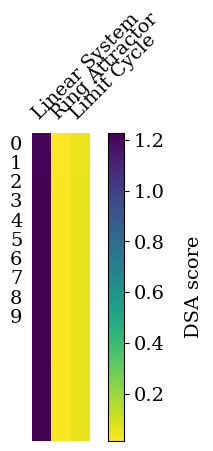

In [17]:
motif_names = ['Linear System', 'Ring Attractor', 'Limit Cycle']
system_names = ['Van Der Pol oscillator', 'Perturbed Ring Attractor', 'Stable Node']
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
im = ax.imshow(score.T, cmap='viridis_r')
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('DSA score', labelpad=15, fontsize=14)
N_M = len(motifs)
N_T = 10
ax.set_xticks(np.arange(N_M))
ax.set_yticks(np.arange(N_T))
ax.set_xticklabels(motif_names)
#ax.set_yticklabels(system_names)
ax.xaxis.set_ticks_position('top')
# Rotate x tick labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")

# Remove spines and ticks
ax.tick_params(top=False, bottom=False, left=False, right=False)
for spine in ax.spines.values():
    spine.set_visible(False)

#plt.savefig('figures/dsa_scores_3motifs.pdf', bbox_inches='tight')